In [1]:
import time
import os
import random
import numpy as np                                                
import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    
                                                     
import gym
from  gymnasium import spaces

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

The below code is my RL extension to and rework of https://www.researchgate.net/publication/360698153_A_Tutorial_on_Structural_Optimization 

In [2]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=6, height=6, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, 1, x] = 1
    normals[0, 1, y] = 1
#     normals[0, -1, x] = 1
#     normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
#     forces[0, 0, x] = 1
    forces[-1, rd, x] = -1
    return normals, forces, density

In [3]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [4]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [5]:
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [6]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [7]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [8]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [9]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

In [10]:
class Model:
    def __init__(self, x):
        self.flag_ = True
#         self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever beam design:')
        plt.imshow(X) 
        plt.show()

In [11]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [12]:
class CantileverEnv(gym.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        DIM=self.args.nelx*self.args.nely
        N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        self.M.action_space_(action, self.x)
        
        tmp, const = fast_stopt(self.args, self.x)
        
        self.step_+=1
        
        self.reward+=(1/tmp)**2
       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if const>0.7:
#             self.reward-=1
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
      
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done, False, dict()

    def reset(self, seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), {}

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass

In [13]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [14]:
# ts=5e6
ts=5e6

In [15]:
# Create log dir
log_dir = "/tmp/gym6c231/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = CantileverEnv()
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)
check_env(env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [16]:
# callback = SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [17]:
start=time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()   

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 2000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 3000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 4000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 5000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 6000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 7000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 8000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 9000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 10000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 11000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timest

Num timesteps: 100000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 101000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 102000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 103000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 104000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 105000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 106000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 107000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 108000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 109000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 110000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 111000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 1

Num timesteps: 193000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 194000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 195000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 196000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 197000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 198000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 199000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 200000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 201000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 202000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 203

Num timesteps: 273000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 274000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 275000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 276000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 277000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 278000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 279000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 280000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 281000
Best mean reward: 0.00 - Last mean reward per episod

Num timesteps: 348000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 349000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 350000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 351000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 352000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 353000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 354000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 355000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 356000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6c231/best_mo

Num timesteps: 432000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 433000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 434000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 435000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 436000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 437000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 438000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 439000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 440000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 441000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 442000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 443000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4

Num timesteps: 532000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 533000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 534000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 535000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 536000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 537000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 538000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 539000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 540000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 541000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 542000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 543000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5

Num timesteps: 632000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 633000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 634000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 635000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 636000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 637000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 638000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 639000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 640000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 641000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 642000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 643000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6

Num timesteps: 732000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 733000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 734000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 735000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 736000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 737000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 738000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 739000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 740000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 741000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 742000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 743000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7

Num timesteps: 832000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 833000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 834000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 835000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 836000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 837000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 838000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 839000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 840000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 841000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 842000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 843000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8

Num timesteps: 932000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 933000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 934000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 935000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 936000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 937000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 938000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 939000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 940000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 941000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 942000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 943000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9

Num timesteps: 1032000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1033000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1034000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1035000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1036000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1037000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1038000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1039000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1040000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1041000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1042000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1043000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1131000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1132000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1133000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1134000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1135000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1136000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1137000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1138000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1139000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1140000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1141000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1142000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1230000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1231000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1232000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1233000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1234000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1235000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1236000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1237000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1238000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1239000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1240000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1241000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1329000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1330000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1331000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1332000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1333000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1334000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1335000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1336000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1337000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1338000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1339000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1340000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1428000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1429000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1430000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1431000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1432000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1433000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1434000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1435000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1436000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1437000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1438000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1439000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1527000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1528000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1529000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1530000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1531000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1532000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1533000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1534000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1535000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1536000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1537000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1538000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1626000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1627000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1628000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1629000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1630000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1631000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1632000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1633000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1634000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1635000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1636000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1637000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1722000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1723000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1724000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1725000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1726000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1727000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1728000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1729000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1730000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1731000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1732000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1733000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1821000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1822000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1823000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1824000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1825000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1826000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1827000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1828000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1829000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1830000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1831000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1832000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1920000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1921000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1922000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1923000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1924000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1925000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1926000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1927000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1928000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1929000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1930000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1931000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2019000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2020000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2021000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2022000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2023000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2024000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2025000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2026000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2027000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2028000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2029000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2030000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2118000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2119000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2120000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2121000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2122000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2123000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2124000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2125000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2126000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2127000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2128000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2129000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2217000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2218000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2219000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2220000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2221000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2222000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2223000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2224000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2225000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2226000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2227000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2228000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2316000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2317000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2318000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2319000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2320000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2321000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2322000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2323000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2324000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2325000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2326000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2327000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2415000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2416000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2417000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2418000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2419000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2420000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2421000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2422000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2423000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2424000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2425000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2426000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2514000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2515000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2516000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2517000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2518000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2519000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2520000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2521000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2522000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2523000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2524000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2525000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2613000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2614000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2615000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2616000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2617000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2618000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2619000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2620000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2621000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2622000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2623000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2624000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2712000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2713000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2714000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2715000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2716000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2717000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2718000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2719000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2720000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2721000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2722000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2723000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2811000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2812000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2813000
Best mean reward: 0.01 - Last mean reward per episode: 0.00
Num timesteps: 2814000
Best mean reward: 0.01 - Last mean reward per episode: 0.00
Num timesteps: 2815000
Best mean reward: 0.01 - Last mean reward per episode: 0.00
Num timesteps: 2816000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2817000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2818000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2819000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2820000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2821000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2822000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2910000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2911000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2912000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2913000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2914000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2915000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2916000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2917000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2918000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2919000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2920000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2921000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3009000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3010000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3011000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3012000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3013000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3014000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3015000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3016000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3017000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3018000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3019000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3020000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3108000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3109000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3110000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3111000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3112000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3113000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3114000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3115000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3116000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3117000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3118000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3119000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3207000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3208000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3209000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3210000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3211000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3212000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3213000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3214000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3215000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3216000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3217000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3218000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3306000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3307000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3308000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3309000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3310000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3311000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3312000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3313000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3314000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3315000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3316000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3317000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3405000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3406000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3407000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3408000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3409000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3410000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3411000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3412000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3413000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3414000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3415000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3416000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3504000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3505000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3506000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3507000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3508000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3509000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3510000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3511000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3512000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3513000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3514000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3515000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3603000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3604000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3605000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3606000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3607000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3608000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3609000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3610000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3611000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3612000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3613000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3614000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3701000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3702000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3703000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3704000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3705000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3706000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 3707000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3708000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3709000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3710000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3711000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3712000
Best mean 

Num timesteps: 3800000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3801000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3802000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3803000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3804000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3805000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3806000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3807000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3808000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3809000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3810000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3811000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3899000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3900000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3901000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3902000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3903000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3904000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3905000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3906000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3907000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3908000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3909000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3910000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3998000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3999000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4000000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4001000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4002000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4003000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4004000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4005000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4006000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4007000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4008000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4009000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4097000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4098000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4099000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4100000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4101000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4102000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4103000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4104000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4105000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4106000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4107000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4108000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4196000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4197000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4198000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4199000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4200000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4201000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4202000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4203000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4204000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4205000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4206000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4207000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4295000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4296000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4297000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4298000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4299000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4300000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4301000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4302000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4303000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4304000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4305000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4306000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4394000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4395000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4396000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4397000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4398000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4399000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4400000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4401000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4402000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4403000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4404000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4405000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4493000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4494000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4495000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4496000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4497000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4498000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4499000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4500000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4501000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4502000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4503000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4504000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4592000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4593000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4594000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4595000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4596000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4597000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4598000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4599000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4600000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4601000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4602000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4603000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4691000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4692000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4693000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4694000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4695000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4696000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4697000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4698000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4699000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4700000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4701000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4702000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4790000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4791000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4792000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4793000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4794000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4795000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4796000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4797000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4798000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4799000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4800000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4801000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4889000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4890000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4891000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4892000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4893000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4894000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4895000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4896000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4897000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4898000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4899000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4900000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4988000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4989000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4990000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4991000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4992000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4993000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4994000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4995000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4996000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4997000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4998000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4999000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

In [18]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 110.92415924866994 min


### Inference

In [19]:
# env.M.flag_=True
env.M.flag_=False
obs=env.reset()
obs=obs[0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.M to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.M` for environment variables or `env.get_wrapper_attr('M')` that will search the reminding wrappers.
  logger.warn(


In [20]:
i=0
while i<1000:
    action, _states = model.predict(obs)
    obs, rewards, dones, _, info = env.step(int(action))
    if dones:
        break
    i+=1

In [21]:
print(i)

36



Final Cantilever beam design:


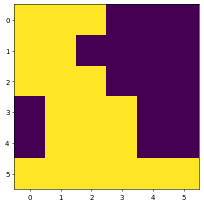

In [22]:
env.render()

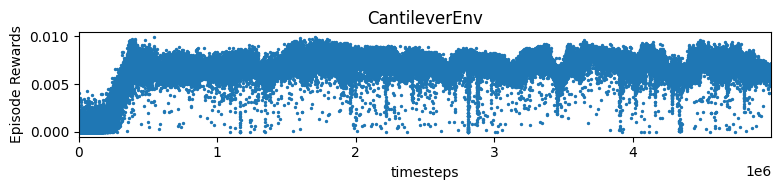

In [23]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [24]:
obs=env.reset()
obs=obs[0]

In [25]:
# Load the agent
model_best = PPO.load(log_dir + "best_model.zip",env=env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [26]:
i=0
while i<1000:
    action, _states = model_best.predict(obs)
    
    obs, rewards, dones, _,info = env.step(int(action))
    if dones:
        break
    i+=1

In [27]:
i

36


Final Cantilever beam design:


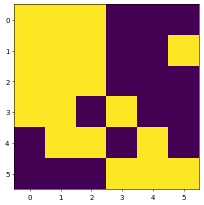

In [28]:
env.render()